In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

from IPython.display import display, clear_output

import nelpy as nel
import nelpy.plotting as npl

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=2.0)

%matplotlib inline

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
import gcsfs
import pandas as pd
import os

load_local = False

if not load_local:
    fs = gcsfs.GCSFileSystem(project='polar-program-784', token='cloud')
    print(fs.ls('kemerelab-data/diba'))

    with fs.open('kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'rb') as fid:
        with pd.HDFStore('gor01vvp01pin01-metadata.h5', mode="r", driver="H5FD_CORE",
                driver_core_backing_store=0,
                driver_core_image=fid.read()
                ) as store:
            df = store['Session_Metadata']
            df2 = store['Subset_Metadata']
            
    with fs.open('kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel', 'rb') as fid:
        jar = nel.load_pkl('',fileobj=fid) # currently requires a specific nelpy branch

else:
    datadirs = ['/Users/ckemere/Development/Data/Buzsaki/']

    fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)
    if fileroot is None:
        raise FileNotFoundError('datadir not found')

    with pd.HDFStore(fileroot + 'gor01vvp01pin01-metadata.h5') as store:
        df = store.get('Session_Metadata')
        df2 = store.get('Subset_Metadata')
        
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_processed_speed.nel')


exp_data = jar.exp_data
aux_data = jar.aux_data
del jar            

['kemerelab-data/diba/', 'kemerelab-data/diba/gor01vvp01-metadata.h5', 'kemerelab-data/diba/gor01vvp01_processed_speed.nel', 'kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel']


# Draw real place fields

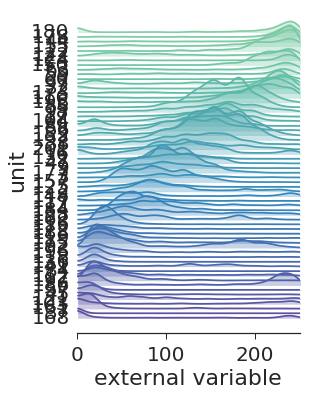

In [3]:
# session_time, segment = '1-22-43', 'long'
# session_time, segment = '16-40-19', 'short'

session_time, segment = '1-22-43', 'long'

PBEs = aux_data[session_time][segment]['PBEs']
st_run = aux_data[session_time][segment]['st_run']
tc = aux_data[session_time][segment]['tc']
tc_placecells = aux_data[session_time][segment]['tc_placecells']

#####################################################################

NUM_COLORS = tc_placecells.n_units * 4

cm = plt.get_cmap('Spectral_r')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
clist = np.roll(clist, 0, axis=0)

npl.set_palette(clist)

with npl.FigureManager(show=True, figsize=(4,6)) as (fig, ax):
    ax = npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), pad=2.5);
    ax.set_xlim(0,250)

# Compare intermodal and cross-modal sequence scores

For our example day, we have 4 sessions (track one/two + long/short each). We also have RUN and PBE data for each session. **Let's start by just looking at the RUN data.** For each session, let's compute:
  1. cross-validated sequence score distributions
  2. cross-session sequence scores

In [4]:
Segments = [
   ('1-22-43', 'long'),
   ('1-22-43', 'short'),
   ('22-24-40', 'long'),
   ('22-24-40', 'short')
]

### Compute cross-validate sequence score distributions for RUN data in 4 sessions

In [5]:
from dask.distributed import Client
client = Client('tcp://127.0.0.1:34253')  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:34253 Dashboard: http://127.0.0.1:8787,Cluster Workers: 32 Cores: 32 Memory: 126.75 GB


In [6]:
import dask
from dask import delayed

def est_model(data, num_states, seed):
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=seed, verbose=False)
    hmm.fit(data)
    return hmm

def score_data(data, hmm):
    seq_lens = np.array([seq.n_bins for seq in data])
    return hmm.score(data) / seq_lens


In [7]:
ds_run = 0.125 # 125 ms bin size for Run
ds_50ms = 0.05 # used for smoothing
ds = 0.02 # 20 ms bin size for PBEs

sigma = 0.25 # 250 ms spike smoothing

num_states = 30

k_folds = 5

In [8]:
# Smooth data
RunData = []
for session_time, segment in Segments:
    print("Loading and smoothing RUN data: {}".format((session_time, segment)))

    s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
    st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

    # smooth and re-bin RUN data:
    bst = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
    RunData.append(bst)


Loading and smoothing RUN data: ('1-22-43', 'long')
Loading and smoothing RUN data: ('1-22-43', 'short')
Loading and smoothing RUN data: ('22-24-40', 'long')
Loading and smoothing RUN data: ('22-24-40', 'short')


In [9]:
sbs = [] # scores_by_session
print("Ingesting data")
for ii, (session_time, segment) in enumerate(Segments):
    print("Run segment: {}".format((session_time, segment)))

    bst = RunData[ii]
    
    X = list(range(bst.n_epochs))

    scores = []
    for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
        print('  fold {}/{}'.format(kk+1, k_folds))

        RunSeqs_train = bst[training]
        RunSeqs_test = bst[validation]

        # train HMM on all training PBEs
        hmm = delayed(est_model)(delayed(RunSeqs_train, traverse=False), num_states, 0)
        
        # compute scores_hmm (log likelihoods) of validation set:
        scores.append(delayed(score_data)(delayed(RunSeqs_test, traverse=False), hmm))
    
    sbs.append(scores)

print("Scoring HMMs")
cv_score_run = dask.compute(*sbs)



Ingesting data
Run segment: ('1-22-43', 'long')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
Run segment: ('1-22-43', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
Run segment: ('22-24-40', 'long')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
Run segment: ('22-24-40', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
Scoring HMMs


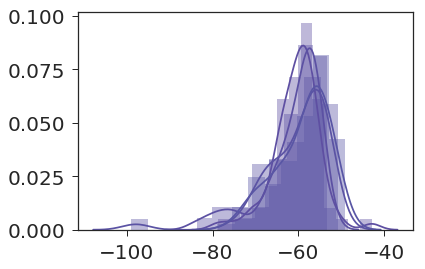

In [10]:
for sess in cv_score_run:
    sns.distplot(np.hstack(sess))


In [11]:
sbs = [] # scores_by_session
for session_time, segment in Segments:
    print("PBE segment: {}".format((session_time, segment)))
    
    PBEs = aux_data[session_time][segment]['PBEs']

    X = list(range(PBEs.n_epochs))

    scores = []
    for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
        print('  fold {}/{}'.format(kk+1, k_folds))

        PBESeqs_train = PBEs[training]
        PBESeqs_test = PBEs[validation]

        # train HMM on all training PBEs
        hmm = delayed(est_model)(delayed(PBESeqs_train, traverse=False), num_states, 0)
        
        # compute scores_hmm (log likelihoods) of validation set:
        scores.append(delayed(score_data)(delayed(PBESeqs_test, traverse=False), hmm))
    
    sbs.append(scores)

print("Scoring HMMs")
cv_score_pbe = dask.compute(*sbs)



PBE segment: ('1-22-43', 'long')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
PBE segment: ('1-22-43', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
PBE segment: ('22-24-40', 'long')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
PBE segment: ('22-24-40', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5
Scoring HMMs


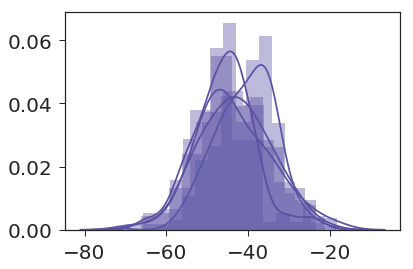

In [12]:
for sess in cv_score_pbe:
    sns.distplot(np.hstack(sess))


### Compute cross-session RUN HMM scores

In [13]:
# Learn models
models = []
for ii, (session_time, segment) in enumerate(Segments):
    print("Building training graph on run segment: {}".format((session_time, segment)))
    model_reps = []
    for repeats in range(10):
        model_reps.append(delayed(est_model)(delayed(RunData[ii], traverse=False), num_states, repeats))
    models.append(model_reps)

run_models = dask.compute(*models)
    
comp = []
description = []
for jj, (ses_data, seg_data) in enumerate(Segments):
    print("Building scoring graph for run segment: {}".format((session_time, segment)))
    scores = []
    desc = []
    for ii, (ses_model, seg_model) in enumerate(Segments):
        rep_scores = []
        for rep in range(10):
            hmm = run_models[ii][rep]
            rep_scores.append(delayed(score_data)(delayed(RunData[jj], traverse=False), hmm))
        scores.append(rep_scores)
        
    comp.append(scores)

print("Running scores")
across_session_run = dask.compute(*comp)



Building training graph on run segment: ('1-22-43', 'long')
Building training graph on run segment: ('1-22-43', 'short')
Building training graph on run segment: ('22-24-40', 'long')
Building training graph on run segment: ('22-24-40', 'short')
Building scoring graph for run segment: ('22-24-40', 'short')
Building scoring graph for run segment: ('22-24-40', 'short')
Building scoring graph for run segment: ('22-24-40', 'short')
Building scoring graph for run segment: ('22-24-40', 'short')
Running scores


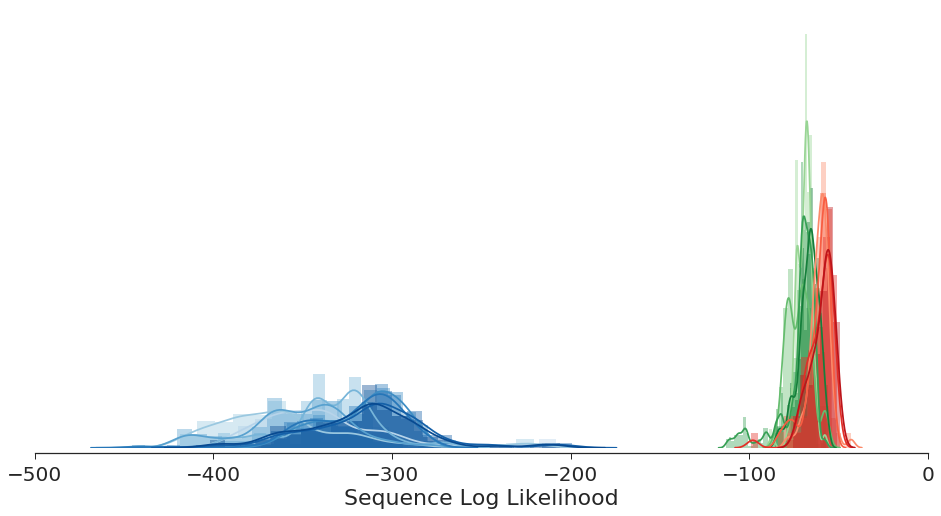

In [14]:
cmap = plt.cm.get_cmap('Blues')
diff_maze = cmap(np.linspace(0.3, 0.9, 8))

cmap = plt.cm.get_cmap('Greens')
same_maze = cmap(np.linspace(0.4, 0.8, 4))

cmap = plt.cm.get_cmap('Reds')
self_maze = cmap(np.linspace(0.4, 0.8, 4))

s_i = 0
d_i = 0

with npl.FigureManager(show=True, figsize=(16,8)) as (fig, ax):
    for ii,pairwise in enumerate(across_session_run):
        for jj,sess in enumerate(pairwise):
            if ii is jj:
                continue
                #sns.distplot(np.hstack(sess), color='darkgreen')
            else:
                if ii//2 == jj//2:
                    sns.distplot(np.hstack(sess), color=same_maze[s_i].tolist())
                    s_i = s_i + 1
                else:
                    sns.distplot(np.hstack(sess), color=diff_maze[d_i].tolist())
                    d_i = d_i + 1
    s_i = 0                
    for sess in cv_score_run:
        sns.distplot(np.hstack(sess), color=self_maze[s_i].tolist())
        s_i = s_i + 1


    plt.xlabel('Sequence Log Likelihood')
    plt.xticks(np.arange(-500,1,100))
    plt.yticks([])
    sns.despine(left=True, offset=5)


### Compute PBE across-segment likelihoods

In [15]:

# Learn models
models = []
for ii, (session_time, segment) in enumerate(Segments):
    print("Building training graph on run segment: {}".format((session_time, segment)))
    model_reps = []
    PBEs = aux_data[session_time][segment]['PBEs']
    for repeats in range(10):
        model_reps.append(delayed(est_model)(delayed(PBEs, traverse=False), num_states, repeats))
    models.append(model_reps)
    
pbe_models = dask.compute(*models)

comp = []
description = []
for jj, (ses_data, seg_data) in enumerate(Segments):
    print("Building scoring graph for run segment: {}".format((ses_data, seg_data)))
    scores = []
    desc = []
    for ii, (ses_model, seg_model) in enumerate(Segments):
        rep_scores = []
        for rep in range(10):
            hmm = pbe_models[ii][rep]
            PBEs = aux_data[ses_data][seg_data]['PBEs']
            rep_scores.append(delayed(score_data)(delayed(PBEs, traverse=False), hmm))
        scores.append(rep_scores)
        
    comp.append(scores)

print("Running scores")
across_session_pbe = dask.compute(*comp)


Building training graph on run segment: ('1-22-43', 'long')
Building training graph on run segment: ('1-22-43', 'short')
Building training graph on run segment: ('22-24-40', 'long')
Building training graph on run segment: ('22-24-40', 'short')
Building scoring graph for run segment: ('1-22-43', 'long')
Building scoring graph for run segment: ('1-22-43', 'short')
Building scoring graph for run segment: ('22-24-40', 'long')
Building scoring graph for run segment: ('22-24-40', 'short')
Running scores


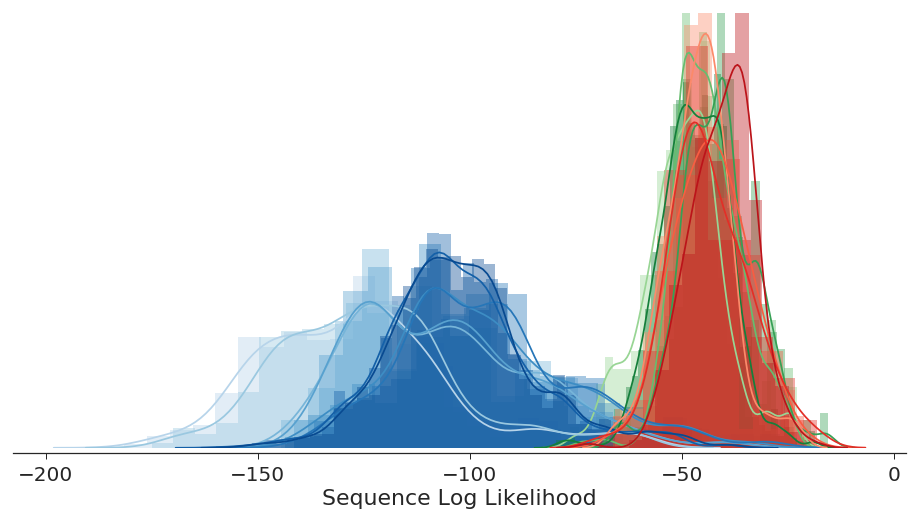

In [16]:
# Plot distribution of model likelihoods with nice colors

s_i = 0
d_i = 0
with npl.FigureManager(show=True, figsize=(16,8)) as (fig, ax):
    for ii,pairwise in enumerate(across_session_pbe):
        for jj,sess in enumerate(pairwise):
            if ii is jj:
                continue
            else:
                if ii//2 == jj//2:
                    sns.distplot(np.hstack(sess), color=same_maze[s_i].tolist())
                    s_i = s_i + 1
                else:
                    sns.distplot(np.hstack(sess), color=diff_maze[d_i].tolist())
                    d_i = d_i + 1
    s_i = 0                
    for sess in cv_score_pbe:
        sns.distplot(np.hstack(sess), color=self_maze[s_i].tolist())
        s_i = s_i + 1

    plt.xlabel('Sequence Log Likelihood')
    plt.xticks(np.arange(-200,1,50))
    plt.yticks([])
    sns.despine(left=True, offset=5)


### Penultimately, let's calculate cross-modal PBE in RUN

In [22]:
import copy
# Smooth data
comp = []
description = []
for jj, (ses_data, seg_data) in enumerate(Segments):
    print("Building scoring graph for run segment: {}".format((ses_data, seg_data)))
    scores = []
    desc = []
    for ii, (ses_model, seg_model) in enumerate(Segments):
        rep_scores = []
        for rep in range(10):
            # Rescale firing rates by differences in bin size (PBEs are smaller bins, so lower rate) 
            hmm = copy.deepcopy(run_models[ii][rep])
            hmm.means_ = hmm.means_ * (ds / ds_run) # scale rates by difference in bin size
            PBEs = aux_data[ses_data][seg_data]['PBEs']
            rep_scores.append(delayed(score_data)(delayed(PBEs, traverse=False), hmm))
        scores.append(rep_scores)
        
    comp.append(scores)

print("Running scores")
pbe_with_run_model = dask.compute(*comp)

Building scoring graph for run segment: ('1-22-43', 'long')
Building scoring graph for run segment: ('1-22-43', 'short')
Building scoring graph for run segment: ('22-24-40', 'long')
Building scoring graph for run segment: ('22-24-40', 'short')
Running scores


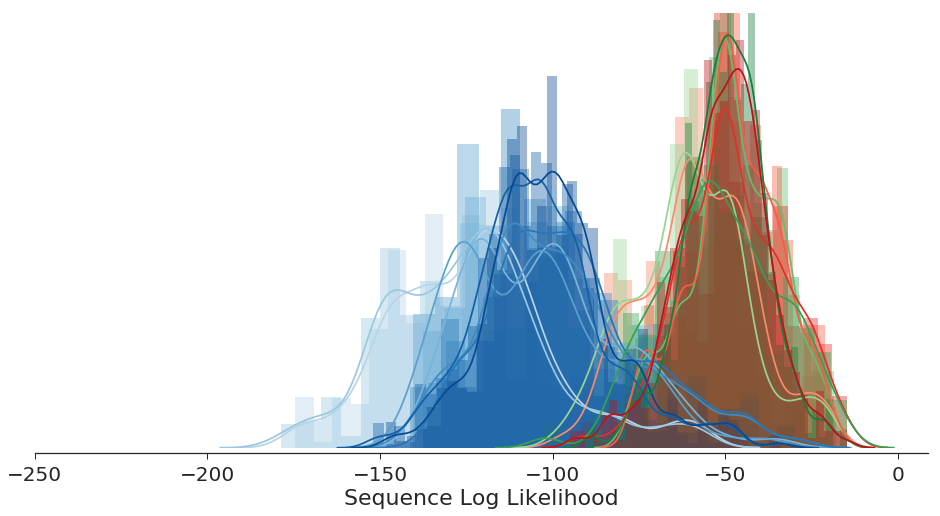

In [19]:
# Plot distribution of model likelihoods with nice colors
z_i = 0
s_i = 0
d_i = 0
with npl.FigureManager(show=True, figsize=(16,8)) as (fig, ax):
    for ii,pairwise in enumerate(pbe_with_run_model):
        for jj,sess in enumerate(pairwise):
            if ii is jj:
                sns.distplot(np.hstack(sess), color=self_maze[z_i].tolist())
                z_i = z_i + 1
            else:
                if ii//2 == jj//2:
                    sns.distplot(np.hstack(sess), color=same_maze[s_i].tolist())
                    s_i = s_i + 1
                else:
                    sns.distplot(np.hstack(sess), color=diff_maze[d_i].tolist())
                    d_i = d_i + 1

    plt.xlabel('Sequence Log Likelihood')
    plt.xticks(np.arange(-250,1,50))
    plt.yticks([])
    sns.despine(left=True, offset=5)

### And finally, let's calculate cross-modal RUN in PBE

In [24]:
# Smooth data
comp = []
description = []
for jj, (ses_data, seg_data) in enumerate(Segments):
    print("Building scoring graph for run segment: {}".format((ses_data, seg_data)))
    scores = []
    desc = []
    for ii, (ses_model, seg_model) in enumerate(Segments):
        rep_scores = []
        for rep in range(10):
            # Rescale firing rates by differences in bin size (PBEs are smaller bins, so lower rate) 
            hmm = copy.deepcopy(pbe_models[ii][rep])
            hmm.means_ = hmm.means_ * (ds_run / ds) # scale rates by difference in bin size
            rep_scores.append(delayed(score_data)(delayed(RunData[jj], traverse=False), hmm))

        scores.append(rep_scores)
        
    comp.append(scores)

print("Running scores")
run_with_pbe_model = dask.compute(*comp)

Building scoring graph for run segment: ('1-22-43', 'long')
Building scoring graph for run segment: ('1-22-43', 'short')
Building scoring graph for run segment: ('22-24-40', 'long')
Building scoring graph for run segment: ('22-24-40', 'short')
Running scores


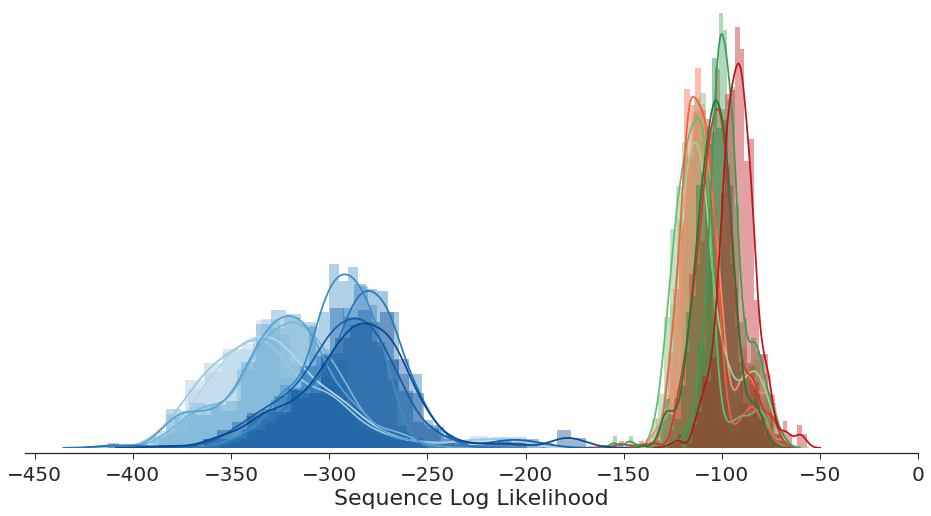

In [28]:
# Plot distribution of model likelihoods with nice colors
z_i = 0
s_i = 0
d_i = 0
with npl.FigureManager(show=True, figsize=(16,8)) as (fig, ax):
    for ii,pairwise in enumerate(run_with_pbe_model):
        for jj,sess in enumerate(pairwise):
            if ii is jj:
                sns.distplot(np.hstack(sess), color=self_maze[z_i].tolist())
                z_i = z_i + 1
            else:
                if ii//2 == jj//2:
                    sns.distplot(np.hstack(sess), color=same_maze[s_i].tolist())
                    s_i = s_i + 1
                else:
                    sns.distplot(np.hstack(sess), color=diff_maze[d_i].tolist())
                    d_i = d_i + 1

    plt.xlabel('Sequence Log Likelihood')
    plt.xticks(np.arange(-450,1,50))
    plt.yticks([])
    sns.despine(left=True, offset=5)

# Compute virtual tuning curves...

In [ ]:
s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin RUN data:
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 6.2 # smoothing std dev in cm
tc_ = nel.TuningCurve1D(bst=bst_run, extern=exp_data[session_time]['pos1d'], n_extern=100, extmin=0, extmax=310, sigma=sigma, min_duration=0)
tc_ = tc.reorder_units()

In [ ]:
# OK - let's think about what we want to do:

# Big question - what is the latent space that describes hippocampal activity?
#  (1) - what does that latent space look like?
#      - transition matrix and firing rate matrix
#      - sparsity, compared with shuffles?
#      - cross-validated virtual tuning curves
#  (2) - we can learn models on both place cell activity and PBEs
#      - are they equivalent?
#       : latent space looks qualitatively similar
#      - how do they differ?
#       : cross-validated likelihood (goodness-of-fit) is more different than shuffles?
#       : is there something to be said about scoring? maybe PBE-in-place cell better than
#          place cell in PBE
#  (3) - can we see replay?


# (0) replicate cross-modal scoring
#    - cross-validated self scoring (train model on subsets, test on the rest)
#    - cross-modal scoring (train model on whole set)
#    - have to deal with sequence length, but can compare by sequence
# 
# (1) cross-validation training curves comparing to shuffles?
#    - this could be the way Kamran suggested (just shuffling the test set)
#    - this could also be the way Etienne suggested (shuffling all the data, then training as usual)
#
# (2) generate sparsity data for transition and rate matrices
#
# (3) Is there a way to think about mutual information??? I think it would be hard, because I think 
#     the operant question would be MI(spikes | position) and MI(spikes | latent state)

### Calculate virtual tuning curves for RUN HMM and compare with PBE

In [ ]:
# session_time, segment = ('16-40-19', 'short') # example session

num_states = 30 # number of states for PBE HMM
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

description = (session_time, segment)
print("session: {}".format(description))

s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
bst = bst_run


pos = exp_data[session_time]['pos1d'] # should this be pos1d?

ext_nx=124
x0=0; xl=310;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

#########################################################
# Generate an HMM trained on all PBEs 
PBEs = aux_data[session_time][segment]['PBEs']
pbe_hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
pbe_hmm.fit(PBEs)
transmat_order = pbe_hmm.get_state_order('transmat')
pbe_hmm.reorder_states(transmat_order)

xpos = pos.asarray(at=bst_run.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = pbe_hmm.fit_ext(X=bst_run, ext=ext_x, n_extern=ext_nx)

pbe_vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
pbe_vtc = pbe_vtc.smooth(sigma=sigma_tc)
pbe_vtc.reorder_units(inplace=True)
#########################################################

k_folds = 3
vtcs_run = []
X = list(range(bst_run.n_epochs))

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
    print('  fold {}/{}'.format(kk+1, k_folds))

    RunSeqs_train = bst[training]
    RunSeqs_test = bst[validation]

    # train HMM on all training PBEs
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
    hmm.fit(RunSeqs_train)

    # reorder states according to transmat ordering
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)

    # compute spatial info on non-shuffled data:
    xpos = pos.asarray(at=RunSeqs_test.centers).yvals

    ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
    ext_x = ext_x.astype(float)
    ext_x[ext_x==0] = np.nan
    ext_x[ext_x>=ext_nx] = np.nan

    extern = hmm.fit_ext(X=RunSeqs_test, ext=ext_x, n_extern=ext_nx)

    vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
    vtc = vtc.smooth(sigma=sigma_tc)
    
    vtc.reorder_units(inplace=True)
    
    vtcs_run.append(vtc)
    

In [ ]:
NUM_COLORS = vtc.n_units + 2

cm = plt.get_cmap('viridis')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

npl.set_palette(clist)

for vtc in vtcs_run:
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    npl.plot_tuning_curves1D(vtc, pad=0.1, ax=axs[0])
    npl.plot_tuning_curves1D(pbe_vtc, pad=0.1, ax=axs[1])
    plt.show()

In [ ]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 0 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))

# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = exp_data[session_time]['spikes']._unit_subset(unit_ids_to_keep)

tc_placecells = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc_placecells.reorder_units(inplace=True)

sta_placecells.reorder_units_by_ids(tc_placecells.unit_ids, inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,4)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 57), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)